# Expresso Customer Churn Prediction

### 1.1 Business Understanding / Project Objective

Customer churn may be defined as the loss of customers by a business, and is used as a key indicator of business health over time. Churn  and must be managed to ensure some stability in the business' survival, (retention) strategy development, and/or growth. 

It is calculated as the percentage of customers that stopped using a company's product or service within a specified timeframe. 

This project is focused on Expresso - a telecommunications company - and aims to predict the likelihood that a customer will churn by identifying and modelling using available data. Possible strategies that may be explored and implemented to improve retention (or reduce churn) may be recommended in this project.

### 1.2 Data Understanding

The dataset contains information about the region of customers, the services that they use, the regularity of service use, and their churn status. The columns in the dataset are described below:

- **user_id**: user ID
- **REGION**: the location of each client
- **TENURE**: duration in the network
- **MONTANT**: top-up amount
- **FREQUENCE_RECH**: number of times the client recharged
- **REVENUE**: monthly income of each client
- **ARPU_SEGMENT**: income over 90 days / 3
- **FREQUENCE**: number of times the client has made an income
- **DATA_VOLUME**: number of connections
- **ON_NET**: inter expresso call
- **ORANGE**: calls to orange
- **TIGO**: calls to Tigo
- **ZONE1**: calls to zones1
- **ZONE2**: calls to zones2
- **MRG**: a client who is going
- **REGULARITY**: number of times the client is active for 90 days
- **TOP_PACK**: the most active packs
- **FREQ_TOP_PACK**: number of times the client has activated the top pack packages
- **CHURN**: variable to predict - Target


## 2.0 Hypothesis

- *Null Hypothesis*: frequence and regularity are the biggest predictors of customer churn.
- *Alternative hypothesis*: frequence and regularity are not the biggest predictors of customer churn.

## 3.0 Toolbox Loading

In [ ]:
# Zindi Data Access
import requests
from tqdm.auto import tqdm

# Data Manipulation
import numpy as np
import pandas as pd
import re
import pickle

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings("ignore")  # Hiding the warnings

# Feature Engineering
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import *
from sklearn.preprocessing import MinMaxScaler,StandardScaler, OneHotEncoder, LabelEncoder

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
!pip install catboost --q
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import *

# Model evaluation
from sklearn import metrics
from sklearn.metrics import *

print("Loading complete.", "Warnings hidden.")

Loading complete. Warnings hidden.


In [ ]:
# Set some display options
## Removing the restriction on columns to display
pd.set_option("display.max_columns", None)

## Set display of floats to 5 decimal places
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## 4.0 Data Exploration

In [ ]:
# Define variables for the training data and Zindi token
data_url = "https://api.zindi.africa/v1/competitions/customer-churn-prediction-challenge-for-azubian/files/Train.csv"
token = {'auth_token': 'ehYe68DnzGrWLBm5DY3dMqap'}

In [ ]:
# Function to download data
def zindi_data_downloader(url, token, file_name):
    # Get the competition data
    competition_data = requests.post(url = data_url, data= token, stream=True)
    
    # Progress bar monitor download
    pbar = tqdm(desc=file_name, total=int(competition_data.headers.get('content-length', 0)), unit='B', unit_scale=True, unit_divisor=512)
    # Create and Write the data to colab drive in chunks
    handle = open(file_name, "wb")
    for chunk in competition_data.iter_content(chunk_size=512): # Download the data in chunks
        if chunk: # filter out keep-alive new chunks
                handle.write(chunk)
        pbar.update(len(chunk))
    handle.close()
    pbar.close()

In [ ]:
# Download the training data
zindi_data_downloader(url = data_url, token = token, file_name = "Train.csv")

# Load the training data
dataset = pd.read_csv("Train.csv")
dataset.head()

Train.csv:   0%|          | 0.00/494M [00:00<?, ?B/s]

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,7ee9e11e342e27c70455960acc80d3f91c1286d1,DAKAR,K > 24 month,20000.00000,47.00000,21602.00000,7201.00000,52.00000,8835.00000,3391.00000,396.00000,185.00000,NaN,NaN,NO,62,On net 200F=Unlimited _call24H,30.00000,0
1,50443f42bdc92b10388fc56e520e4421a5fa655c,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
2,da90b5c1a9b204c186079f89969aa01cb03c91b2,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN,0
3,364ec1b424cdc64c25441a444a16930289a0051e,SAINT-LOUIS,K > 24 month,7900.00000,19.00000,7896.00000,2632.00000,25.00000,9385.00000,27.00000,46.00000,20.00000,NaN,2.00000,NO,61,"Data:490F=1GB,7d",7.00000,0
4,d5a5247005bc6d41d3d99f4ef312ebb5f640f2cb,DAKAR,K > 24 month,12350.00000,21.00000,12351.00000,4117.00000,29.00000,9360.00000,66.00000,102.00000,34.00000,NaN,NaN,NO,56,All-net 500F=2000F;5d,11.00000,0


In [ ]:
# Check the shape of the training data
dataset.shape

(1077024, 19)

In [ ]:
# Look at summary information about the columns
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077024 entries, 0 to 1077023
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   user_id         1077024 non-null  object 
 1   REGION          652687 non-null   object 
 2   TENURE          1077024 non-null  object 
 3   MONTANT         699139 non-null   float64
 4   FREQUENCE_RECH  699139 non-null   float64
 5   REVENUE         714669 non-null   float64
 6   ARPU_SEGMENT    714669 non-null   float64
 7   FREQUENCE       714669 non-null   float64
 8   DATA_VOLUME     547261 non-null   float64
 9   ON_NET          683850 non-null   float64
 10  ORANGE          629880 non-null   float64
 11  TIGO            432250 non-null   float64
 12  ZONE1           84898 non-null    float64
 13  ZONE2           68794 non-null    float64
 14  MRG             1077024 non-null  object 
 15  REGULARITY      1077024 non-null  int64  
 16  TOP_PACK        626129 non-null   ob

From the information above, we note that out of the 18 columns, only 5 have no missing values. The columns therefore have to be assessed, and necessary action taken on the columns to deal with the missing values.

For ease of reading, all column names will also be cast to lowercase.

In [ ]:
# Cast all column names to lowercase
dataset.columns = dataset.columns.str.lower()

In [ ]:
# Get the percentages of missing values for each column
percent_missing = dataset.isnull().sum() * 100 / len(dataset)
missing_value_df = pd.DataFrame({"percent_missing": percent_missing})
missing_value_df.sort_values("percent_missing", inplace=True)
missing_value_df

,percent_missing
user_id,0.00000
regularity,0.00000
mrg,0.00000
churn,0.00000
tenure,0.00000
revenue,33.64410
arpu_segment,33.64410
frequence,33.64410
frequence_rech,35.08603
montant,35.08603


In [ ]:
# Check for duplicates
dataset[dataset.duplicated()]

,user_id,region,tenure,montant,frequence_rech,revenue,arpu_segment,frequence,data_volume,on_net,orange,tigo,zone1,zone2,mrg,regularity,top_pack,freq_top_pack,churn


From the dataset preview and the info above, we make the following observations:
- Given the extent of missing values for zone1 and zone2 (over 90% each), they will be dropped.
- With "tigo" also having more than 50% of data missing, it will be dropped. Since it gives information on calls to a particular network, all other columns containinng information on calls to networks will be dropped. This means that, along with "tigo","on_net" and "orange" will also be dropped.
- There are no duplicates in the dataset.

In [ ]:
# Drop the columns with lots of missing values
dataset.drop(columns = ["zone1", "zone2", "tigo", "orange", "on_net"], inplace = True)

### 4.1 Exploration of Numeric Columns

In [ ]:
# Look at the descriptive statistics of the columns with numeric values
numerics = [column for column in dataset.columns if (dataset[column].dtype != "O")]
print("Summary table of the Descriptive Statistics of Columns with Numeric Values")
dataset[numerics].describe().T

Summary table of the Descriptive Statistics of Columns with Numeric Values


,count,mean,std,min,25%,50%,75%,max
montant,699139.00000,5529.21090,7104.73795,20.00000,1000.00000,3000.00000,7350.00000,470000.00000
frequence_rech,699139.00000,11.52376,13.26194,1.00000,2.00000,7.00000,16.00000,131.00000
revenue,714669.00000,5506.05080,7175.62501,1.00000,1000.00000,3000.00000,7360.00000,532177.00000
arpu_segment,714669.00000,1835.35596,2391.87090,0.00000,333.00000,1000.00000,2453.00000,177392.00000
frequence,714669.00000,13.97444,14.68706,1.00000,3.00000,9.00000,20.00000,91.00000
data_volume,547261.00000,3368.80172,12898.92804,0.00000,0.00000,258.00000,2905.00000,1702309.00000
regularity,1077024.00000,28.04450,22.28861,1.00000,6.00000,24.00000,51.00000,62.00000
freq_top_pack,626129.00000,9.26245,12.24232,1.00000,2.00000,5.00000,12.00000,624.00000
churn,1077024.00000,0.18755,0.39035,0.00000,0.00000,0.00000,0.00000,1.00000


From the summary table above, we notice some interesting things about the means and medians of the columns. To ensure that our actions on the missing values do not skew the data further or enforce any existing biases in the data, we will check for outliers in the columns before making a final determination on the nulls. This will be done by visualizing the distributions of the numeric columns with boxplots.

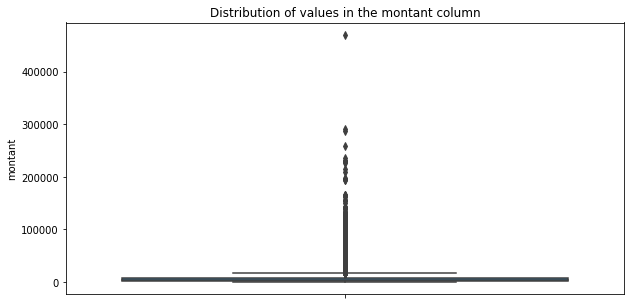

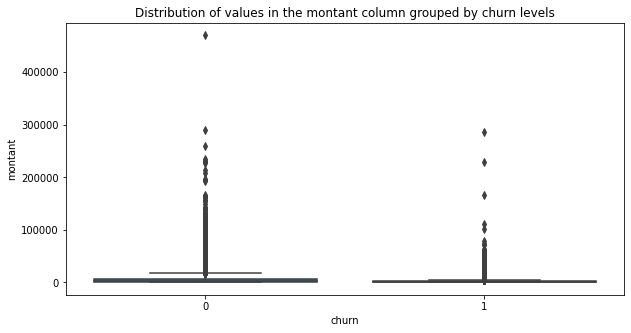

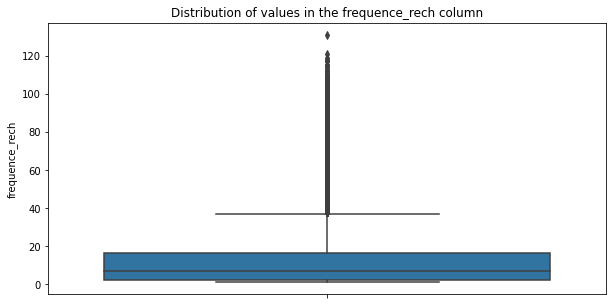

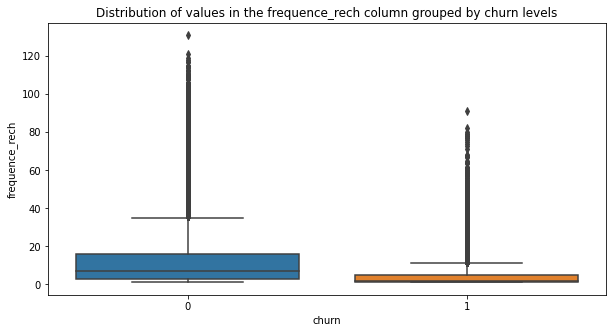

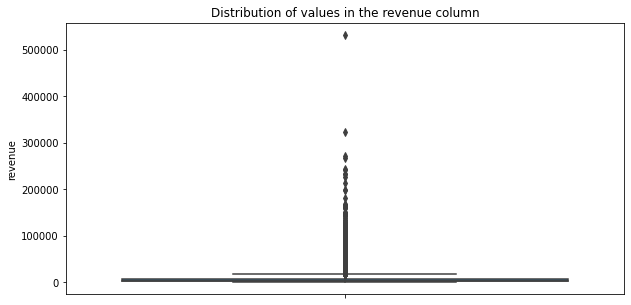

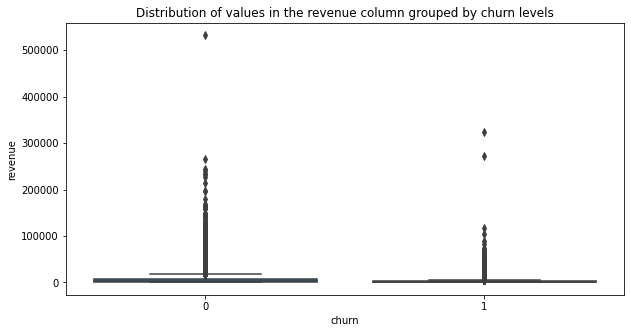

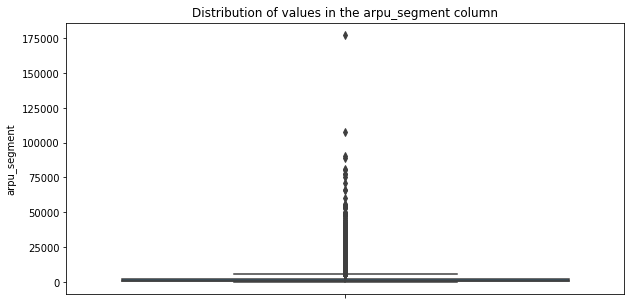

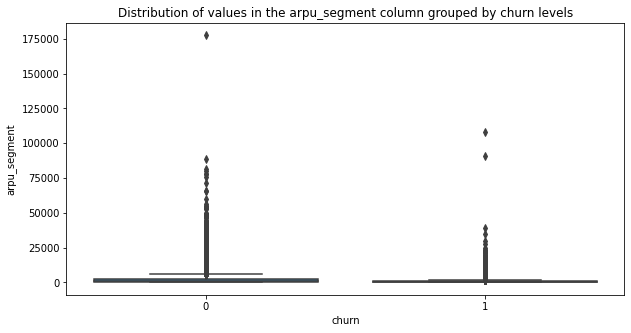

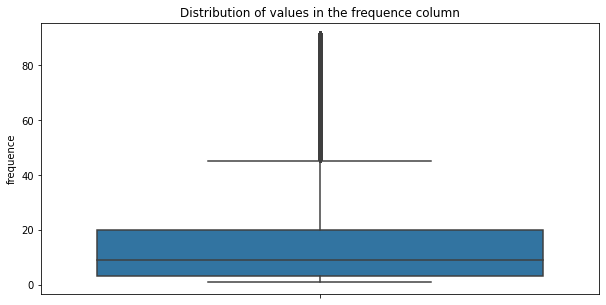

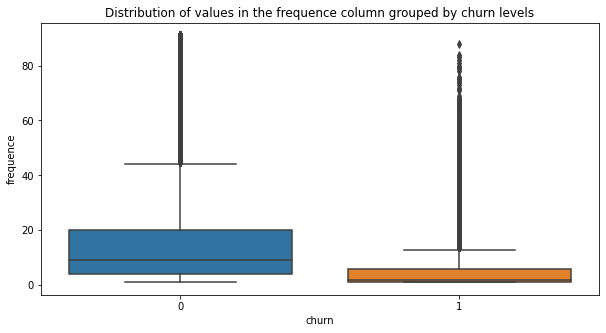

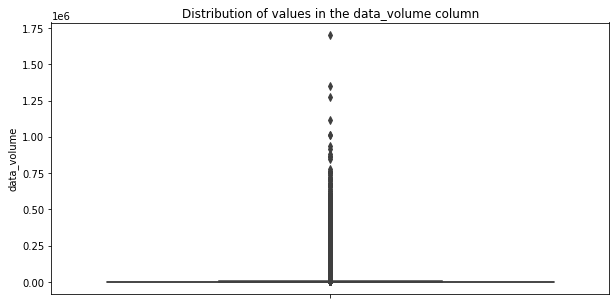

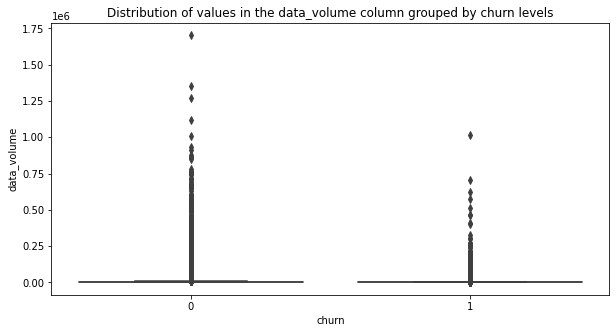

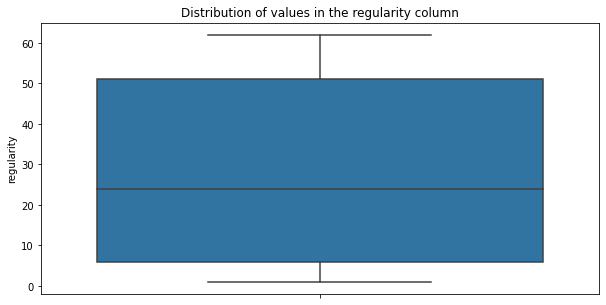

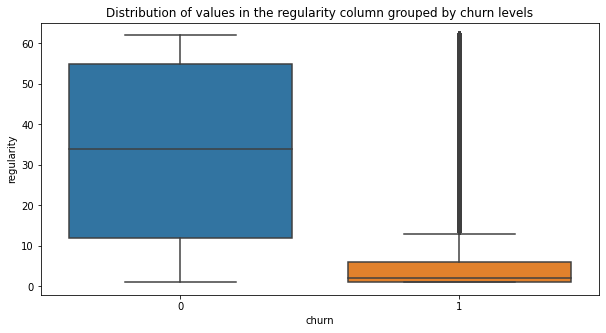

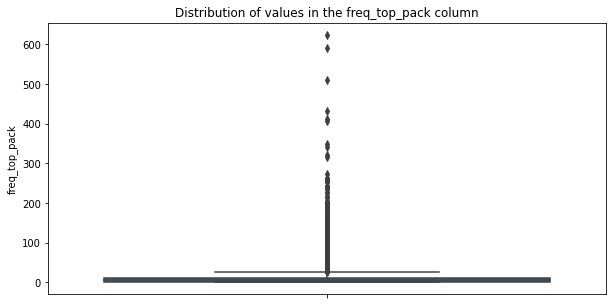

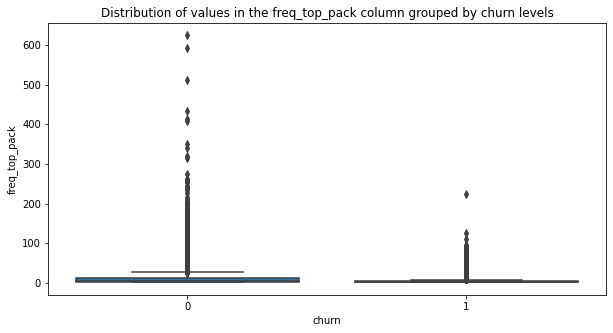

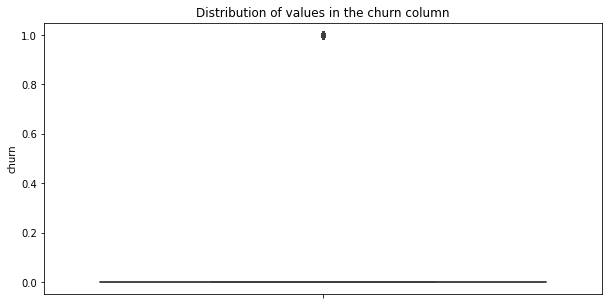

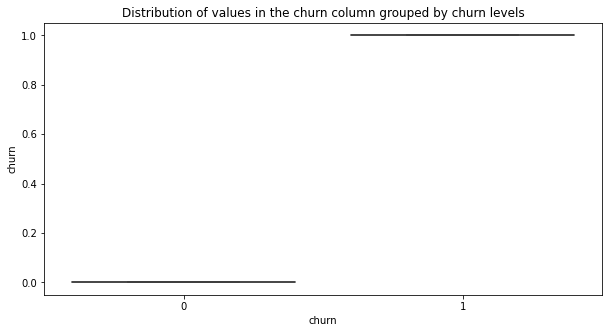

In [ ]:
 # Visualize the distribution of the numeric columns
for column in dataset[numerics]:
  plt.figure(figsize=(10,5))
  sns.boxplot(y = dataset[column]).set(title = f"Distribution of values in the {column} column")
  plt.show()
  print("\n")

  plt.figure(figsize=(10,5))
  sns.boxplot(y = dataset[column], x = dataset["churn"]).set(title = f"Distribution of values in the {column} column grouped by churn status")
  plt.show()
  print("\n"*3)

From the summary table above and the boxplots above, we note the following about the various numeric columns:
1. montant:
	- The median top-up amount is about 3,000.00 currency units, while the average is about 5,529.21 currency units. The minimum and maximum top-up amounts are 20 and 470,000 currency units respectively. This column featured significant outliers
	- When grouped by their churn status, the churned clients had a relatively lower upper limit.
2. frequence_rech
	- The number of times clients recharged ranged from 1 to 131 times, with an average of about 12 times and a median of 7 times. The significant difference between the mean and the median is an indication of the effects of outliers (values beyond 40 times).
	- Similar to the "montant" column, when grouped by their churn status, clients who churned had comparatively less recharge frequency (about 10 times) as compared to clients who stayed (about 38 times).
3. revenue
	- The monthly income per client ranged from 1 to 532,177 currency units. The average value was 5,506.05 and the median was about 3,000 currency units.
	- Here too, the boxplot showed significant outliers. Looking through the lens of churn status, clients who churned had less revenue over the period as compared to the clients who stayed.
4. arpu_segment
	- Similar to the revenue column, the income over 90 days per client had significant outliers, with its values ranging from 0 to 177,392 currency units. It had a mean of about 1,835.36 and a median of about 1,000 currency units.
	- With regard to their churn status, clients who stayed had much higher values in this column as compared to the clients who churned.
5. frequence
	- The median frequence was 9 times as compared to the mean of about 14 times. This is partly understandable given the presence of outliers (values above the 42 times mark)
6. data_volume
	- The number of connections per observation ranged from 0 to 1,702,309, with a median of 258 and a mean of 3,368.80 - indicating the skewing effects of huge outliers in the column.
7. regularity
	- The values in this column range from 1 to 62, with a mean of about 28 times and a median of 24 times. 
	- clients who were active for more than 10 days stayed more than other clients. A large number of clients who churned were active for less than 10 days out of 90 days.
8. freq_top_pack
	- The average number of times clients activated their top pack packages was about 9 times, as compared to the median of 5. The minimum and maximum values were 1 and 624 respectively. With 75% of the data having values less than or equal to 12, the maximum value is an indication of the presence of outliers as can be seen in the boxplot.
	- Higher levels of purchases of one's top package indicated that the client was likely to stay.
9. churn
	- The barplot of the value counts in the churn column shows a significant imbalance in the data as about 80% of the data are observations on clients who churned. Hence, we may want to balance the dataset before training models on it.

From the boxplots, we notice that with the exception of "regularity" and "churn" (which has only 2 values), all the other columns have significant outliers. These are likely to skew the mean, as such, the missing values in those columns will be filled with their respective medians, which are much less likely to be affected by outliers.

<AxesSubplot:>

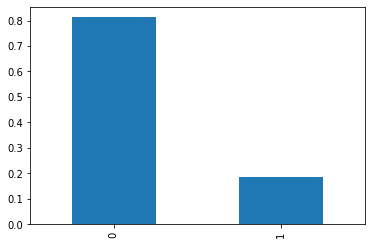

In [ ]:
# Check the value counts of the target column (churn)
dataset["churn"].value_counts(normalize = True).plot(kind = "bar")

In [ ]:
# Fill the numeric columns with their respective mean values
dataset["montant"].fillna((dataset["montant"].mean()), inplace=True)
dataset["frequence_rech"].fillna((dataset["frequence_rech"].mean()), inplace=True)
dataset["arpu_segment"].fillna((dataset["arpu_segment"].mean()), inplace=True)
dataset["frequence"].fillna((dataset["frequence"].mean()), inplace=True)
dataset["data_volume"].fillna((dataset["data_volume"].mean()), inplace=True)
dataset["freq_top_pack"].fillna((dataset["freq_top_pack"].mean()), inplace=True)

In [ ]:
# Confirm filling of nulls with means
percent_missing = dataset.isnull().sum() * 100 / len(dataset)
missing_value_df = pd.DataFrame({"percent_missing": percent_missing})
missing_value_df.sort_values("percent_missing", inplace=True)
missing_value_df

,percent_missing
user_id,0.00000
tenure,0.00000
montant,0.00000
frequence_rech,0.00000
arpu_segment,0.00000
frequence,0.00000
data_volume,0.00000
mrg,0.00000
regularity,0.00000
freq_top_pack,0.00000


### 4.2 Exploration of Categorical Columns

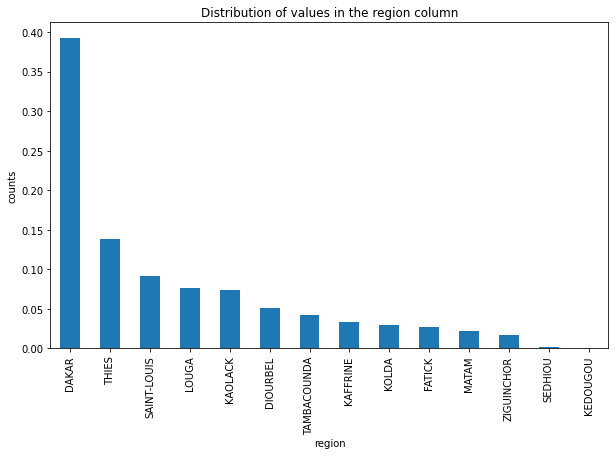

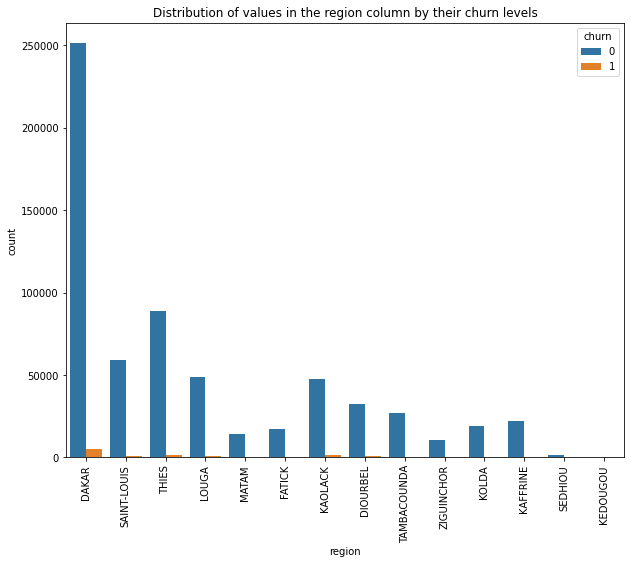

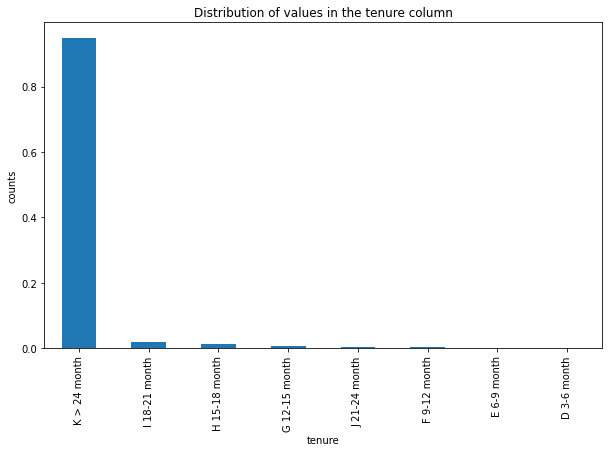

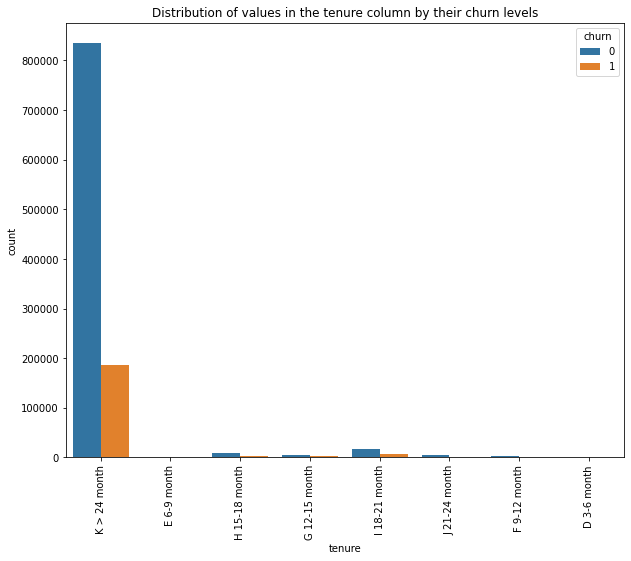

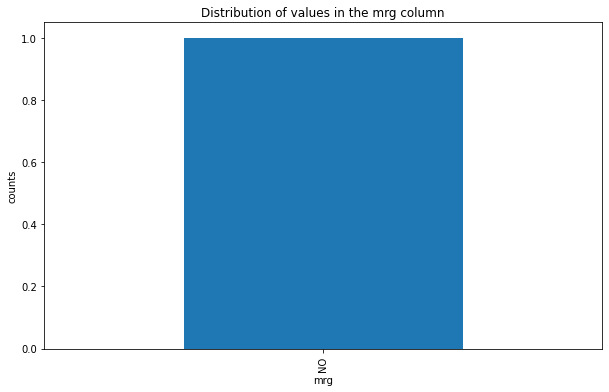

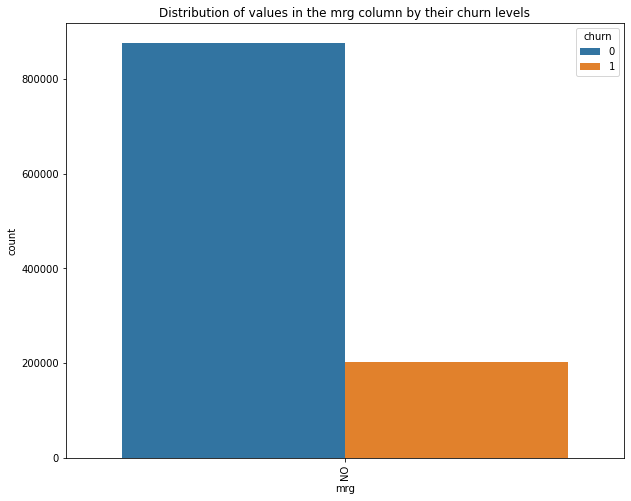

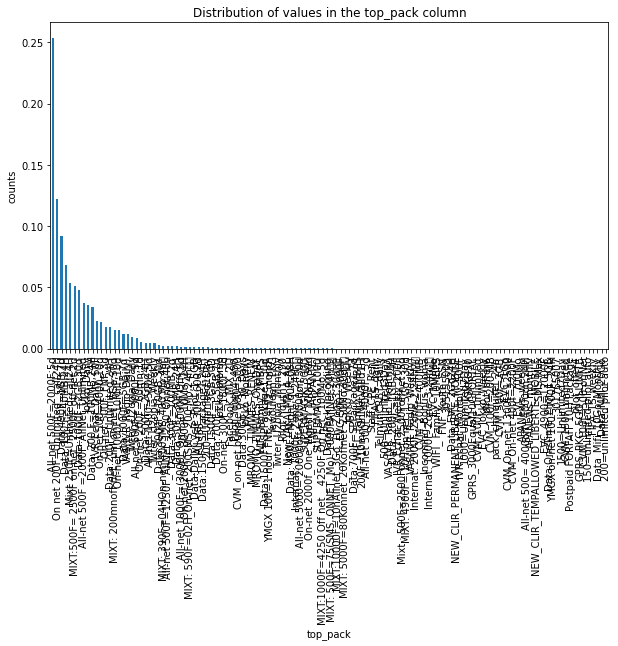

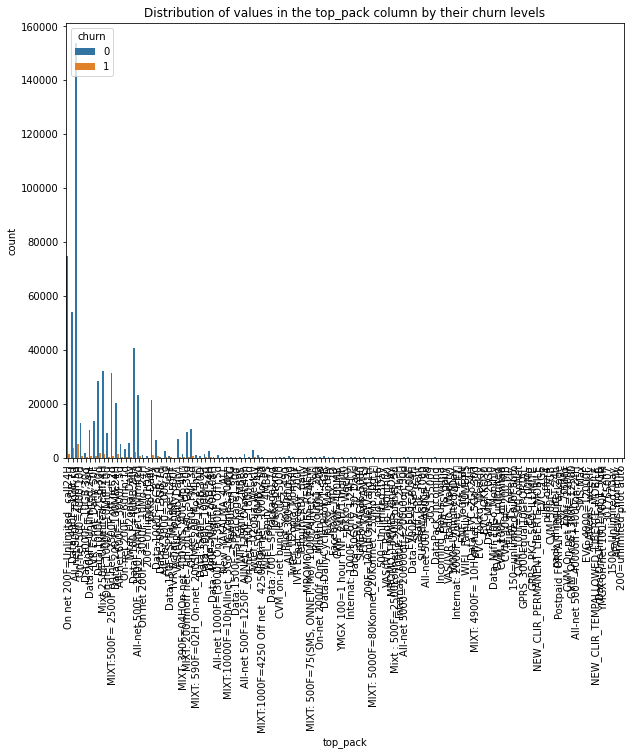

In [ ]:
# Visualizing the distribution of the columns with categorical values and their churn levels
categoricals = [column for column in dataset.columns if (dataset[column].dtype == "O")]
categoricals.remove("user_id")

for column in dataset[categoricals].columns:
  plt.figure(figsize=(10,6))
  # Visualize the distribution of the categories in the column
  dataset[column].value_counts(normalize=True).plot(kind='bar').set(title = f"Distribution of values in the {column} column")
  plt.ylabel('counts')
  plt.xlabel(column)
  plt.show()
  print("\n")

  # Visualize the distribution of the categories in the column by their churn levels
  plt.figure(figsize=(10, 8))
  sns.countplot(data = dataset, x= column, hue = "churn").set(title = f"Distribution of values in the {column} column by their churn levels")
  plt.xticks(rotation = 90)
  plt.show()
  print("\n")

For the categorical columns, here are some key notes from their distributions:
1. region
	- Dakar is the region with most clients (about 39%) , followed by Thies (about 14%) and Saint-Louis (about 10%) in that order. The 

2. tenure
	- Most customers had been with Expresso for over 24 months. This was matched by the churn levels, with most churned customers falling within that tenure group. This was followed by the 18 - 21 months tenure group in both cases.

3. mrg: This column had only one value "NO" for the observations.

4. top_pack: This column had too many variables, making it difficult to derive any useful insights about the data and the clients.

In [ ]:
# Confirm filling of columns with the percentages of missing values
percent_missing = dataset.isnull().sum() * 100 / len(dataset)
missing_value_df = pd.DataFrame({"percent_missing": percent_missing})
missing_value_df.sort_values("percent_missing", inplace=True)
missing_value_df

,percent_missing
user_id,0.00000
tenure,0.00000
montant,0.00000
frequence_rech,0.00000
arpu_segment,0.00000
frequence,0.00000
data_volume,0.00000
mrg,0.00000
regularity,0.00000
freq_top_pack,0.00000


In [ ]:
# Confirm the unique values of the mrg column
dataset["mrg"].value_counts()

NO    1077024
Name: mrg, dtype: int64

## 5.0 Feature Engineering
### 5.1 Feature Encoding

In [ ]:
# Looking at the unique values in each column
dataset.nunique()

user_id           1077024
region                 14
tenure                  8
montant              4358
frequence_rech        120
revenue             31810
arpu_segment        14063
frequence              92
data_volume         32460
mrg                     1
regularity             62
top_pack              126
freq_top_pack         207
churn                   2
dtype: int64

**Initial columns to drop**
- Due to the *low variability* of the "mrg" column, it will be dropped.
- For the opposite reason - *too much variability* - the "top_pack" column will also be dropped
- The "region" column is also a big risk since it is likely to add a lot of dimensionality to the work, and may cause a significant slowdown in training. It will also be dropped in the meantime.
- Since "revenue" gives the same information as "arpu_segment", the "revenue" column will be dropped since the "arpu_segment" provides a more narrow scope of information (90-days).
- The above will be dropped along with the "user_id" which is unique for every user, and will not provide any useful information to the models.

In [ ]:
# Drop the useless columns
dataset.drop(columns = ["user_id", "mrg", "top_pack", "region", "revenue"], inplace = True)

In [ ]:
# Encode the TENURE column
l_encoder = LabelEncoder()
dataset["tenure"] = l_encoder.fit_transform(dataset["tenure"])

In [ ]:
# Create a copy of the dataset
complete_set = dataset.copy()
complete_set.head()

,tenure,montant,frequence_rech,arpu_segment,frequence,data_volume,regularity,freq_top_pack,churn
0,7,20000.00000,47.00000,7201.00000,52.00000,8835.00000,62,30.00000,0
1,7,5529.21090,11.52376,1835.35596,13.97444,3368.80172,3,9.26245,0
2,7,5529.21090,11.52376,1835.35596,13.97444,3368.80172,1,9.26245,0
3,7,7900.00000,19.00000,2632.00000,25.00000,9385.00000,61,7.00000,0
4,7,12350.00000,21.00000,4117.00000,29.00000,9360.00000,56,11.00000,0


In [ ]:
# View a high-level overview of the dataset
complete_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077024 entries, 0 to 1077023
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   tenure          1077024 non-null  int64  
 1   montant         1077024 non-null  float64
 2   frequence_rech  1077024 non-null  float64
 3   arpu_segment    1077024 non-null  float64
 4   frequence       1077024 non-null  float64
 5   data_volume     1077024 non-null  float64
 6   regularity      1077024 non-null  int64  
 7   freq_top_pack   1077024 non-null  float64
 8   churn           1077024 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 74.0 MB


### 5.2 Feature Selection

#### 5.2.1 Correlation Matrix

In [ ]:
# Looking at the correlation between the variables in the merged dataframe
correlation = pd.DataFrame(complete_set.corr())

# Defining a colourscale for the correlation plot
colorscale = [[0.0, "rgb(255,255,255)"], [0.2, "rgb(255, 255, 153)"],
              [0.4, "rgb(153, 255, 204)"], [0.6, "rgb(179, 217, 255)"],
              [0.8, "rgb(240, 179, 255)"], [1.0, "rgb(255, 77, 148)"]]

# Plotting the Correlation Matrix
fig = px.imshow(correlation,
                text_auto= ".3f",
                aspect= "auto",
                labels= {"color": "Correlation Coefficient"},
                contrast_rescaling= "minmax",
                color_continuous_scale= colorscale
                )
fig.update_xaxes(side="top")
fig.show()

The correlation matrix presents a more comprehensive view on the nature of the relationships between the various variables  in the dataset, but it is not so clear due to the number of features. 

One thing that does stand out is the perfect positive correlation between "revenue" and "arpu_segment". The "arpu_segment" column will therefore be dropped before modelling.

## 6.0 Modelling

In [ ]:
# Defining the target & predictor variables
X = complete_set.drop(columns=["churn"])
y = complete_set["churn"]

# Splitting the dataframe into train and test
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state= 24, stratify= y)

In [ ]:
# Putt the training dataset together for further splitting and modelling
train_data = X_train.join(y_train, on=X_train.index)
train_data.head()

,tenure,montant,frequence_rech,arpu_segment,frequence,data_volume,regularity,freq_top_pack,churn
252414,7,2250.00000,7.00000,750.00000,8.00000,3368.80172,43,3.00000,0
268753,7,5529.21090,11.52376,1835.35596,13.97444,3368.80172,1,9.26245,1
117153,7,4550.00000,10.00000,1217.00000,11.00000,3368.80172,49,5.00000,0
70341,7,5529.21090,11.52376,1835.35596,13.97444,3368.80172,1,9.26245,1
417693,7,11450.00000,25.00000,4067.00000,37.00000,3368.80172,43,21.00000,0


In [ ]:
# What is the shape of the training data?
train_data.shape

(753916, 9)

In [ ]:
# Put the eval dataset together for future model evaluation
eval_data = X_eval.join(y_eval, on= X_eval.index)
eval_data.head()

,tenure,montant,frequence_rech,arpu_segment,frequence,data_volume,regularity,freq_top_pack,churn
479752,7,3300.00000,12.00000,1132.00000,13.00000,0.00000,51,10.00000,0
652536,7,5529.21090,11.52376,1835.35596,13.97444,3368.80172,1,9.26245,0
21009,7,500.00000,1.00000,333.00000,5.00000,0.00000,42,9.26245,0
977909,7,500.00000,1.00000,167.00000,1.00000,3368.80172,24,1.00000,0
288527,7,3000.00000,6.00000,1000.00000,6.00000,3368.80172,15,6.00000,0


In [ ]:
# What is the shape of the test data?
eval_data.shape

(323108, 9)

### 6.1 Balance the Training Data

In [ ]:
# Split the training dataframe for the SMOTE balancing
X = train_data.drop(columns=["churn"])
y = train_data["churn"]

In [ ]:
# Resample the training dataframe using SMOTE
smote = SMOTE(sampling_strategy="minority", n_jobs=-1, random_state=24)
X, y = smote.fit_resample(X, y)
y.value_counts()

0    612521
1    612521
Name: churn, dtype: int64

In [ ]:
# Apply train_test_split to the SMOTE-sampled training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 24, stratify=y)
y_train.value_counts()

1    428765
0    428764
Name: churn, dtype: int64

In [ ]:
# Define the list of columns to scale
numerics.remove("churn")
numerics.remove("revenue")
numerics

['montant',
 'frequence_rech',
 'arpu_segment',
 'frequence',
 'data_volume',
 'regularity',
 'freq_top_pack']

In [ ]:
# Scale the numeric columns
scaler = MinMaxScaler()
X_train[numerics] = scaler.fit_transform(X_train[numerics])
X_test[numerics] = scaler.transform(X_test[numerics])

In [ ]:
# Define the models
log_reg_model = LogisticRegression(random_state=24)
dt_model = DecisionTreeClassifier(random_state=24)
rf_model = RandomForestClassifier(random_state=24)
xgb_model = XGBClassifier(random_state=24)
catb_model = CatBoostClassifier(metric_period=100, random_state=24)
lgb_model = lgb.LGBMClassifier(random_state=24)

# Create a dictionary of the models
smote_models = {
    "Logistic Regressor": log_reg_model,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "CatBoost": catb_model,
    "LightGBM": lgb_model
}

In [ ]:
# Defining a helper function to fit models to data and score them
def classification_fit_and_score(models, X_train= X_train, X_test= X_test, 
                                 y_train= y_train, y_test= y_test):
    
    # List to collect the results
    results = []
    
    # Looping through the models to fit and score each
    for name, model in models.items():

        # fitting to the training data
        model.fit(X_train, y_train)

        # making predictions
        y_pred = model.predict(X_test)
        
        # Append model performance results
        results.append([
        name,
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        accuracy_score(y_test, y_pred),
        roc_auc_score(y_test, y_pred)
        ])

        # Print Classification Report
        model_classification_report = classification_report(y_test, y_pred)
        print(f"{name} Model Classification Report", "\n", model_classification_report, "\n")
        
        # Defining the Confusion Matrix
        model_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred)).reset_index(drop=True)
        print(f"{name} Confusion Matrix:", "\n", model_confusion_matrix, "\n")
        
        # Visualizing the Confusion Matrix
        # Display Confusion Matrix directly from predictions
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        plt.show()
        print("\n")

        # Calculate and show the AUC and ROC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()
        print("\n")
        
        print(f"{name} AUC score: {roc_auc_score(y_test, y_pred)}")

        print("\n")
        print("----- ----- "*6)
        print("\n")
        print("----- ----- "*6)
        print("\n")
    
    # Put the results together
    eval_df = pd.DataFrame(results, columns=["model", "precision", "recall", "f1_score", "accuracy", "auc"])
    eval_df.set_index("model", inplace=True)
    eval_df.sort_values(by = ["auc","f1_score", "accuracy", "recall"], ascending = False, inplace = True)

    return eval_df

Logistic Regressor Model Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.75      0.81    183757
           1       0.78      0.89      0.83    183756

    accuracy                           0.82    367513
   macro avg       0.83      0.82      0.82    367513
weighted avg       0.83      0.82      0.82    367513
 

Logistic Regressor Confusion Matrix: 
         0       1
0  138068   45689
1   19951  163805 



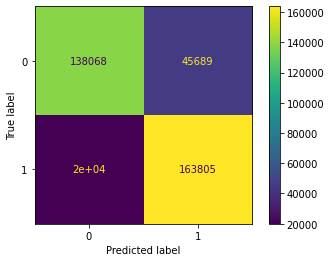

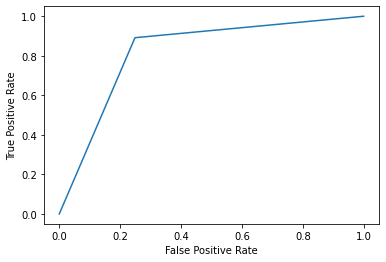



Logistic Regressor AUC score: 0.8213942636924702


----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


Decision Tree Model Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.78      0.84    183757
           1       0.81      0.92      0.86    183756

    accuracy                           0.85    367513
   macro avg       0.85      0.85      0.85    367513
weighted avg       0.85      0.85      0.85    367513
 

Decision Tree Confusion Matrix: 
         0       1
0  143401   40356
1   15533  168223 



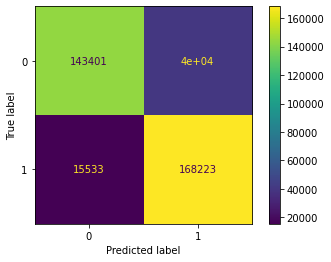

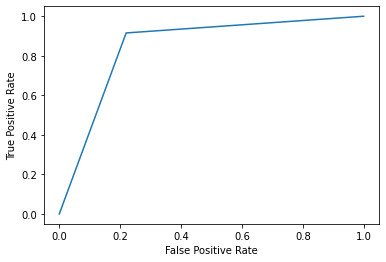



Decision Tree AUC score: 0.8479266516906208


----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


Random Forest Model Classification Report 
               precision    recall  f1-score   support

           0       0.91      0.81      0.86    183757
           1       0.83      0.92      0.87    183756

    accuracy                           0.86    367513
   macro avg       0.87      0.86      0.86    367513
weighted avg       0.87      0.86      0.86    367513
 

Random Forest Confusion Matrix: 
         0       1
0  148651   35106
1   14786  168970 



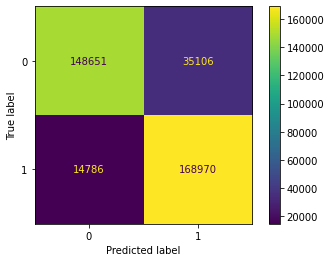

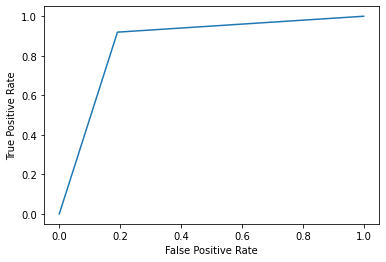



Random Forest AUC score: 0.8642444084704262


----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


XGBoost Model Classification Report 
               precision    recall  f1-score   support

           0       0.91      0.81      0.86    183757
           1       0.83      0.92      0.87    183756

    accuracy                           0.87    367513
   macro avg       0.87      0.87      0.86    367513
weighted avg       0.87      0.87      0.86    367513
 

XGBoost Confusion Matrix: 
         0       1
0  149634   34123
1   15396  168360 



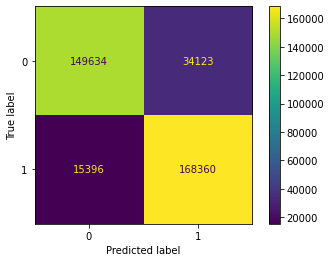

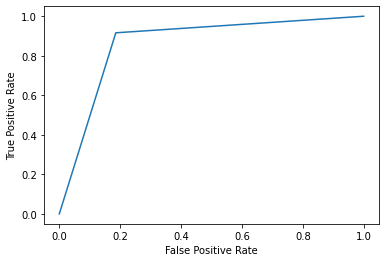



XGBoost AUC score: 0.8652593267602886


----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


Learning rate set to 0.18426
0:	learn: 0.5785996	total: 157ms	remaining: 2m 36s
100:	learn: 0.3255276	total: 18s	remaining: 2m 40s
200:	learn: 0.3182017	total: 33.8s	remaining: 2m 14s
300:	learn: 0.3157945	total: 50.6s	remaining: 1m 57s
400:	learn: 0.3142497	total: 1m 6s	remaining: 1m 39s
500:	learn: 0.3131419	total: 1m 22s	remaining: 1m 22s
600:	learn: 0.3121180	total: 1m 38s	remaining: 1m 5s
700:	learn: 0.3112361	total: 1m 53s	remaining: 48.4s
800:	learn: 0.3105023	total: 2m 8s	remaining: 32s
900:	learn: 0.3097294	total: 2m 25s	remaining: 16s
999:	learn: 0.3090671	total: 2m 41s	remaining: 0us
CatBoost Model Classification Report 
               precision    recall  f1-score   support

           0       0.91      0.81      0.86    183757
           1       0.83      0.92      0.87    183756

   

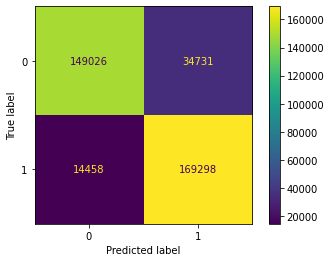

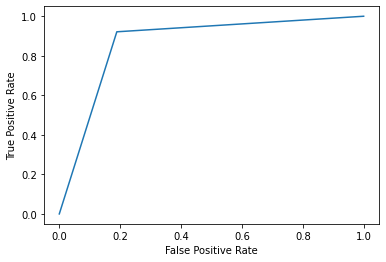



CatBoost AUC score: 0.8661572656268224


----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


LightGBM Model Classification Report 
               precision    recall  f1-score   support

           0       0.91      0.81      0.85    183757
           1       0.82      0.92      0.87    183756

    accuracy                           0.86    367513
   macro avg       0.87      0.86      0.86    367513
weighted avg       0.87      0.86      0.86    367513
 

LightGBM Confusion Matrix: 
         0       1
0  147964   35793
1   15351  168405 



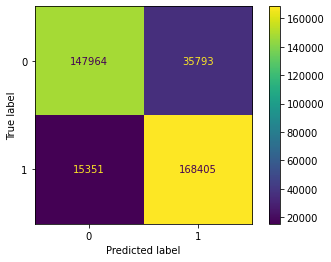

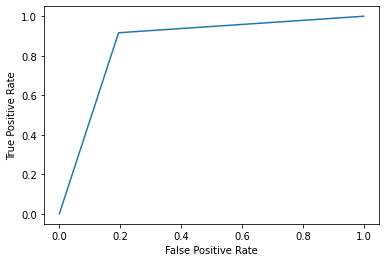



LightGBM AUC score: 0.8608377271610624


----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 




,precision,recall,f1_score,accuracy,auc
model,,,,,
CatBoost,0.82977,0.92132,0.87315,0.86616,0.86616
XGBoost,0.83148,0.91621,0.87179,0.86526,0.86526
Random Forest,0.82798,0.91953,0.87136,0.86424,0.86424
LightGBM,0.82471,0.91646,0.86817,0.86084,0.86084
Decision Tree,0.80652,0.91547,0.85755,0.84793,0.84793
Logistic Regressor,0.78191,0.89143,0.83308,0.82139,0.82139


In [ ]:
# Fit and evaluate the models
model_performances = classification_fit_and_score(smote_models)
model_performances

### 6.2 Evaluation on the Test Data

In [ ]:
# Splitting the test data
test_X = eval_data.drop(columns= ["churn"])
test_y = eval_data["churn"]

In [ ]:
# Scale the numeric columns
test_X[numerics] = scaler.transform(test_X[numerics])

In [ ]:
# Refit the top models to the training data
## CatBoost Model
catb_model = CatBoostClassifier(metric_period=100, random_state=24)
catb_model.fit(X_train, y_train)

## LightGBM
lgb_model = lgb.LGBMClassifier(random_state=24)
lgb_model.fit(X_train, y_train)

## XGBoost
xgb_model = XGBClassifier(random_state=24)
xgb_model.fit(X_train, y_train)

# Create a dictionary of the top models
select_models = {
    "CatBoost": catb_model,
    "LightGBM": lgb_model,
    "XGBoost": xgb_model
}

Learning rate set to 0.18426
0:	learn: 0.5785996	total: 275ms	remaining: 4m 34s
100:	learn: 0.3255276	total: 16.5s	remaining: 2m 27s
200:	learn: 0.3182017	total: 32.1s	remaining: 2m 7s
300:	learn: 0.3157945	total: 47.7s	remaining: 1m 50s
400:	learn: 0.3142497	total: 1m 5s	remaining: 1m 37s
500:	learn: 0.3131419	total: 1m 21s	remaining: 1m 21s
600:	learn: 0.3121180	total: 1m 38s	remaining: 1m 5s
700:	learn: 0.3112361	total: 1m 54s	remaining: 48.6s
800:	learn: 0.3105023	total: 2m 9s	remaining: 32.2s
900:	learn: 0.3097294	total: 2m 25s	remaining: 15.9s
999:	learn: 0.3090671	total: 2m 40s	remaining: 0us


In [ ]:
# Defining a helper function to evaluate the models at a go
def model_evaluation(fit_models, X_test, y_test):
    lst = []
    for name, model in fit_models.items():
        pred = model.predict(X_test)
           
        print("Confusion Matrix for the", name, "model")
        
        # Confusion Matrix
        conf_mat = confusion_matrix(y_test, pred, labels =[0,1])
        conf_mat = pd.DataFrame(conf_mat,columns=["Actual Positive", "Actual Negative"], 
                                index=["Predict Positive", "Predict Negative"])
        

        # Visualize the Confusion Matrix
        f, ax = plt.subplots()
        sns.heatmap(conf_mat,
                    annot= True,
                    linewidth= 1.0,
                    fmt= ".0f",
                    cmap= "RdPu",
                    ax= ax
                   )
        plt.title("The Confusion Matrix of the Predictions")
        plt.show()
        print("\n")


        # Calculate and show the AUC and ROC
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()
        print("\n")
        print(f"{name} AUC score: {roc_auc_score(y_test, pred)}")
        print("\n")


        lst.append([
            name,
            precision_score(y_test, pred),
            recall_score(y_test, pred),
            f1_score(y_test, pred),
            accuracy_score(y_test, pred),
            roc_auc_score(y_test, pred)
        ])

    
        # Feature importances
        importance = model.feature_importances_
        importance = pd.DataFrame(importance, columns=["score"]).reset_index()
        importance["Feature"] = list(X.columns)
        importance.drop(columns=["index"], inplace=True)

        importance.sort_values(by="score", ascending=False, ignore_index=True, inplace=True)

        # Plotting the feature importances
        fig = px.bar(importance, x="Feature", y="score")
        fig.show()
        
        print("\n")
        print("----- ----- "*6)
        print("\n")
        print("----- ----- "*6)
        print("\n")

    eval_df = pd.DataFrame(lst, columns=["model", "precision", "recall", "f1_score", "accuracy", "auc"])
    eval_df.set_index("model", inplace=True)
    eval_df.sort_values(by = ["auc", "f1_score", "accuracy", "recall"], ascending=False, inplace= True)

    return eval_df

Confusion Matrix for the CatBoost model


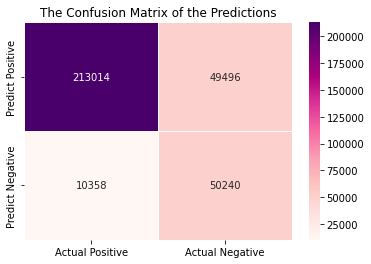

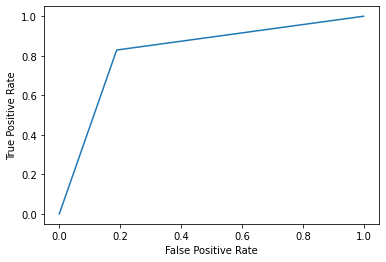



CatBoost AUC score: 0.8202606293442863






----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


Confusion Matrix for the LightGBM model


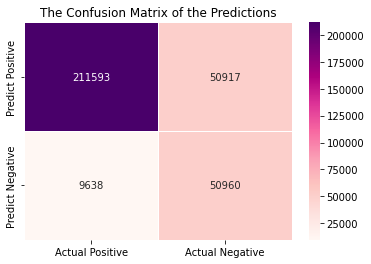

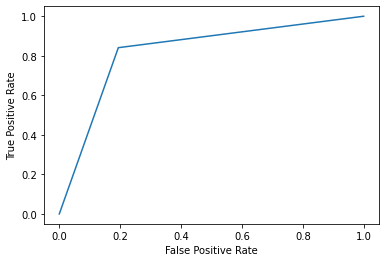



LightGBM AUC score: 0.8234948559098896






----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


Confusion Matrix for the XGBoost model


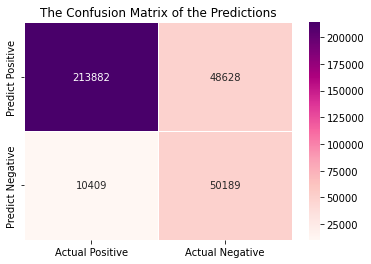

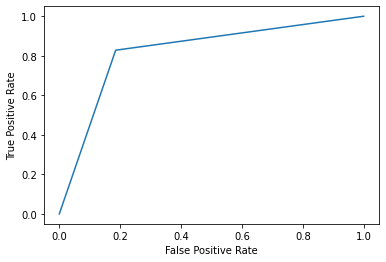



XGBoost AUC score: 0.8214930937286984






----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 


----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 




,precision,recall,f1_score,accuracy,auc
model,,,,,
LightGBM,0.50021,0.84095,0.62730,0.81259,0.82349
XGBoost,0.50790,0.82823,0.62966,0.81728,0.82149
CatBoost,0.50373,0.82907,0.62669,0.81476,0.82026


In [ ]:
# Evaluate the top models
final_model_eval = model_evaluation(fit_models = select_models, X_test = test_X, y_test = test_y)
final_model_eval

## 7.0 Predict on the Unseen Data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import test data and submission sample
test_df =  pd.read_csv(r"/content/drive/MyDrive/waid/Azubi Africa BAP/Capstone/Test.csv")
test_df.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,51fe4c3347db1f8571d18ac03f716c41acee30a4,MATAM,I 18-21 month,2500.00000,5.00000,2500.00000,833.00000,5.00000,0.00000,64.00000,70.00000,NaN,NaN,NaN,NO,35,All-net 500F=2000F;5d,5.00000
1,5ad5d67c175bce107cc97b98c4e37dcc38aa7f3e,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,2,NaN,NaN
2,5a4db591c953a8d8f373877fad37aaf4268899a1,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NO,22,NaN,NaN
3,8bf9b4d8880aeba1c9a0da48be78f12e629be37c,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,6,NaN,NaN
4,c7cdf2af01e9fa95bf498b68c122aa4b9a8d10df,SAINT-LOUIS,K > 24 month,5100.00000,7.00000,5637.00000,1879.00000,15.00000,7783.00000,30.00000,24.00000,0.00000,0.00000,NaN,NO,60,"Data:1000F=2GB,30d",4.00000


In [ ]:
# Data url and token
# test_url = "https://api.zindi.africa/v1/competitions/customer-churn-prediction-challenge-for-azubian/files/Test.csv"

# # Download the testuation data
# zindi_data_downloader(url = test_url, token = token, file_name = "Test.csv")

# Loading the data
# test_df = pd.read_csv("Test.csv")
# test_df.head()

In [ ]:
# Check the shape of the test data
test_df.shape

(190063, 18)

In [ ]:
# Cast all column names to lowercase
test_df.columns = test_df.columns.str.lower()

In [ ]:
# Fill the numeric columns with their respective mean values
test_df["montant"].fillna((test_df["montant"].mean()), inplace=True)
test_df["frequence_rech"].fillna((test_df["frequence_rech"].mean()), inplace=True)
test_df["arpu_segment"].fillna((test_df["arpu_segment"].mean()), inplace=True)
test_df["frequence"].fillna((test_df["frequence"].mean()), inplace=True)
test_df["data_volume"].fillna((test_df["data_volume"].mean()), inplace=True)
test_df["freq_top_pack"].fillna((test_df["freq_top_pack"].mean()), inplace=True)

test_df.head()

,user_id,region,tenure,montant,frequence_rech,revenue,arpu_segment,frequence,data_volume,on_net,orange,tigo,zone1,zone2,mrg,regularity,top_pack,freq_top_pack
0,51fe4c3347db1f8571d18ac03f716c41acee30a4,MATAM,I 18-21 month,2500.00000,5.00000,2500.00000,833.00000,5.00000,0.00000,64.00000,70.00000,NaN,NaN,NaN,NO,35,All-net 500F=2000F;5d,5.00000
1,5ad5d67c175bce107cc97b98c4e37dcc38aa7f3e,NaN,K > 24 month,5506.54776,11.48394,NaN,1828.75028,13.93967,3358.42115,NaN,NaN,NaN,NaN,NaN,NO,2,NaN,9.23433
2,5a4db591c953a8d8f373877fad37aaf4268899a1,NaN,K > 24 month,5506.54776,11.48394,NaN,1828.75028,13.93967,0.00000,NaN,NaN,NaN,NaN,NaN,NO,22,NaN,9.23433
3,8bf9b4d8880aeba1c9a0da48be78f12e629be37c,NaN,K > 24 month,5506.54776,11.48394,NaN,1828.75028,13.93967,3358.42115,NaN,NaN,NaN,NaN,NaN,NO,6,NaN,9.23433
4,c7cdf2af01e9fa95bf498b68c122aa4b9a8d10df,SAINT-LOUIS,K > 24 month,5100.00000,7.00000,5637.00000,1879.00000,15.00000,7783.00000,30.00000,24.00000,0.00000,0.00000,NaN,NO,60,"Data:1000F=2GB,30d",4.00000


In [ ]:
# Encode the "tenure" column
test_df["tenure"] = l_encoder.transform(test_df["tenure"])
complete_test = test_df.copy()

In [ ]:
# Drop the useless columns
complete_test.drop(columns = ["user_id", "mrg", "top_pack", "region", "zone1", "zone2", "tigo", "orange", "on_net", "revenue"], inplace= True)

In [ ]:
# Create a column for the target variable
complete_test["churn"] = 0

In [ ]:
# Define the target and predictor variables
test_X = complete_test.drop(columns = ["churn"])
test_y = complete_test["churn"]

In [ ]:
# Scale the numeric columns
test_X[numerics] = scaler.transform(test_X[numerics])

In [ ]:
# Predict on the unseen data - LightGBM model
lightgbm_pred = lgb_model.predict_proba(test_X)
lightgbm_pred

array([[0.94618104, 0.05381896],
       [0.12943596, 0.87056404],
       [0.65954371, 0.34045629],
       ...,
       [0.12943596, 0.87056404],
       [0.85137946, 0.14862054],
       [0.12943596, 0.87056404]])

In [ ]:
# Predict on the unseen data - XGBoost model
xgb_pred = xgb_model.predict_proba(test_X)
xgb_pred

array([[0.9756174 , 0.02438257],
       [0.00684267, 0.9931573 ],
       [0.01141667, 0.9885833 ],
       ...,
       [0.00684267, 0.9931573 ],
       [0.14583397, 0.85416603],
       [0.00684267, 0.9931573 ]], dtype=float32)

**Averaging**

In [ ]:
# Find the average of the two probabilities
lxgb_pred = (lightgbm_pred + xgb_pred) / 2
lxgb_pred

array([[0.96089922, 0.03910077],
       [0.06813932, 0.93186068],
       [0.33548019, 0.66451981],
       ...,
       [0.06813932, 0.93186068],
       [0.49860672, 0.50139328],
       [0.06813932, 0.93186068]])

In [ ]:
# # Loading the data
# sample_submission = pd.read_csv(r"/content/drive/MyDrive/waid/Azubi Africa BAP/Capstone/SampleSubmission.csv")
# print(sample_submission.head())
# print("\n")

# # Create the sample_submission
# sample_submission["CHURN"] = lxgb_pred
# print(sample_submission.head())

# # Export the sample submission
# sample_submission.to_csv("Averaging_Submission_13.csv", index= False)
# #sample_submission.to_csv(r"/content/drive/MyDrive/waid/Azubi Africa BAP/Capstone/Averaging_Submission_11.csv", index=False)

                                    user_id  CHURN
0  51fe4c3347db1f8571d18ac03f716c41acee30a4      0
1  5ad5d67c175bce107cc97b98c4e37dcc38aa7f3e      0
2  5a4db591c953a8d8f373877fad37aaf4268899a1      0
3  8bf9b4d8880aeba1c9a0da48be78f12e629be37c      0
4  c7cdf2af01e9fa95bf498b68c122aa4b9a8d10df      0


                                    user_id  CHURN
0  51fe4c3347db1f8571d18ac03f716c41acee30a4      0
1  5ad5d67c175bce107cc97b98c4e37dcc38aa7f3e      1
2  5a4db591c953a8d8f373877fad37aaf4268899a1      1
3  8bf9b4d8880aeba1c9a0da48be78f12e629be37c      1
4  c7cdf2af01e9fa95bf498b68c122aa4b9a8d10df      0


In [ ]:
# Load the sample submission file
# submission_url = "https://api.zindi.africa/v1/competitions/customer-churn-prediction-challenge-for-azubian/files/SampleSubmission.csv"

# # Download the evaluation data
# zindi_data_downloader(url = submission_url, token = token, file_name = "SampleSubmission.csv")

# # Loading the data
# sample_submission = pd.read_csv(r"/content/drive/MyDrive/waid/Azubi Africa BAP/Capstone/SampleSubmission.csv")
# sample_submission.head()

In [ ]:
# # Check the shape of the submission data
# sample_submission.shape

In [ ]:
# # Create the sample_submission
# sample_submission["CHURN"] = lxgb_pred
# sample_submission.head()

In [ ]:
# # Export the sample submission
# sample_submission.to_csv("Submission_10.csv", index= False)
# sample_submission.to_csv(r"/content/drive/MyDrive/waid/Azubi Africa BAP/Capstone/Submission_10.csv", index=False)

## 8 Export ML Items

In [ ]:
# # Export the requirements
# requirements = "\n".join(f"{m.__name__}=={m.__version__}" for m in globals().values() if getattr(m, "__version__", None))

# with open("requirements.txt", "w") as f:
#     f.write(requirements)

In [ ]:
# # Create a dictionary of objects to export
# exports = {"encoder": l_encoder,
#            "scaler": scaler,
#            "model": xgb_model}

# # Export the dictionary with Pickle
# with open("App_toolkit", "wb") as file:
#     pickle.dump(exports, file)

In [ ]:
# # Exporting the model
# xgb_model.save_model("xgb_model.json")